BloodCells 
Dataset: https://www.kaggle.com/datasets/paultimothymooney/blood-cells?fbclid=IwAR0LazkA2E1azm5Obm2kEmoX1gdk8wVdFimCgw-mrdGyqG9Y_5qlbTWKUfE

### Dataset Download

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%cd /content/drive/MyDrive/BloodCells

/content/drive/MyDrive/BloodCells


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/BloodCells"

In [ ]:
!kaggle datasets download -d paultimothymooney/blood-cells

 97% 105M/108M [00:00<00:00, 174MB/s] 
100% 108M/108M [00:00<00:00, 171MB/s]


In [ ]:
!unzip blood-cells.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8050.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8167.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8283.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8324.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8379.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8577.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8587.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8655.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8701.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_872.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8864.jpeg  
  inflating: dataset2-mast

### Starting Code

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 6.9 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import tensorflow_addons as tfa
from keras import backend as K
from PIL import Image
import cv2
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import Accuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, SpecificityAtSensitivity
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float16)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_OCEAN):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

## Resnet50

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input, decode_predictions

In [ ]:
train_dir = "/content/drive/MyDrive/BloodCells/dataset2-master/dataset2-master/images/TRAIN"
test_dir = "/content/drive/MyDrive/BloodCells/dataset2-master/dataset2-master/images/TEST"

In [ ]:
model1 = ResNet50(include_top=False,input_shape=(224, 224, 3), weights='imagenet')

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
input_shape = (224,224)

In [ ]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)


datagen_test = ImageDataGenerator(rescale=1./255)


batch_size = 32
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)


Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [ ]:
generator_train.class_indices
CLASS_NAMES = list(generator_train.class_indices.keys())
CLASS_NAMES

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

In [ ]:
num_classes = generator_train.num_classes
num_classes

4

In [ ]:
def print_layer_trainable():
    for layer in model1.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))


print_layer_trainable()

True:	input_1
True:	conv1_pad
True:	conv1_conv
True:	conv1_bn
True:	conv1_relu
True:	pool1_pad
True:	pool1_pool
True:	conv2_block1_1_conv
True:	conv2_block1_1_bn
True:	conv2_block1_1_relu
True:	conv2_block1_2_conv
True:	conv2_block1_2_bn
True:	conv2_block1_2_relu
True:	conv2_block1_0_conv
True:	conv2_block1_3_conv
True:	conv2_block1_0_bn
True:	conv2_block1_3_bn
True:	conv2_block1_add
True:	conv2_block1_out
True:	conv2_block2_1_conv
True:	conv2_block2_1_bn
True:	conv2_block2_1_relu
True:	conv2_block2_2_conv
True:	conv2_block2_2_bn
True:	conv2_block2_2_relu
True:	conv2_block2_3_conv
True:	conv2_block2_3_bn
True:	conv2_block2_add
True:	conv2_block2_out
True:	conv2_block3_1_conv
True:	conv2_block3_1_bn
True:	conv2_block3_1_relu
True:	conv2_block3_2_conv
True:	conv2_block3_2_bn
True:	conv2_block3_2_relu
True:	conv2_block3_3_conv
True:	conv2_block3_3_bn
True:	conv2_block3_add
True:	conv2_block3_out
True:	conv3_block1_1_conv
True:	conv3_block1_1_bn
True:	conv3_block1_1_relu
True:	conv3_block1

In [ ]:
last_layer = model1.get_layer('conv5_block3_out').output
out = Flatten()(last_layer)
out = Dense(1024, activation='relu', name='dense_1')(out)
out = Dropout(0.5)(out)
out = Dense(512, activation='relu', name='dense_2')(out)
out = Dense(num_classes, activation='softmax', name='prediction')(out)
new_model = Model(model1.input, out)

In [ ]:
# new_model = Sequential()

# new_model.add(conv_model)

# new_model.add(Flatten())

# new_model.add(Dense(1024, activation='relu'))
# new_model.add(Dropout(0.5))
# new_model.add(Dense(512, activation='relu'))

# new_model.add(Dense(4, activation='softmax'))

In [ ]:
optimizer = Adam(learning_rate=1e-5)
loss = 'categorical_crossentropy'
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), 
           FalseNegatives(name='fn'), 'accuracy' , Precision(name='precision'), Recall(name='recall'), tfa.metrics.F1Score(num_classes, name='f1'), 
           AUC(name='auc'), SpecificityAtSensitivity(0.5, num_thresholds=200, name='sen')]


new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
epochs = 20

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

# steps_per_epoch = 20
# steps_test = 100
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/20
311/311 [==============================] - 193s 557ms/step - loss: 1.0735 - tp: 5219.0000 - fp: 2942.0000 - tn: 26929.0000 - fn: 4738.0000 - accuracy: 0.5937 - precision: 0.6395 - recall: 0.5242 - f1: 0.5930 - auc: 0.8282 - sen: 0.9116 - val_loss: 5.3308 - val_tp: 624.0000 - val_fp: 1863.0000 - val_tn: 5598.0000 - val_fn: 1863.0000 - val_accuracy: 0.2509 - val_precision: 0.2509 - val_recall: 0.2509 - val_f1: 0.1003 - val_auc: 0.5019 - val_sen: 0.5005
Epoch 2/20
311/311 [==============================] - 168s 538ms/step - loss: 0.3180 - tp: 8580.0000 - fp: 1071.0000 - tn: 28800.0000 - fn: 1377.0000 - accuracy: 0.8742 - precision: 0.8890 - recall: 0.8617 - f1: 0.8744 - auc: 0.9816 - sen: 0.9981 - val_loss: 2.2375 - val_tp: 482.0000 - val_fp: 1421.0000 - val_tn: 6040.0000 - val_fn: 2005.0000 - val_accuracy: 0.2509 - val_precision: 0.2533 - val_recall: 0.1938 - val_f1: 0.1700 - val_auc: 0.4998 - val_sen: 0.4969
Epoch 3/20
311/311 [==============================] - 165s 529ms/ste

In [ ]:
new_model.save('/content/drive/MyDrive/BloodCells/saved_models/bloodcells_resnet50.h5')

### Resnet50 Accuracy and Loss

In [ ]:
new_model = keras.models.load_model('/content/drive/MyDrive/BloodCells/saved_models/bloodcells_resnet50.h5')

In [ ]:
steps_test = generator_test.n / batch_size

In [ ]:
scores = new_model.evaluate_generator(generator_test, steps_test)
scores

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[1.5508676767349243,
 2194.0,
 292.0,
 7169.0,
 293.0,
 0.8821873664855957,
 0.8825422525405884,
 0.8821873664855957,
 array([0.8598879 , 0.99272436, 0.8484849 , 0.8305932 ], dtype=float32),
 0.9360750317573547,
 0.9777509570121765]

Text(0.5, 1.0, 'Accuracy Curves')

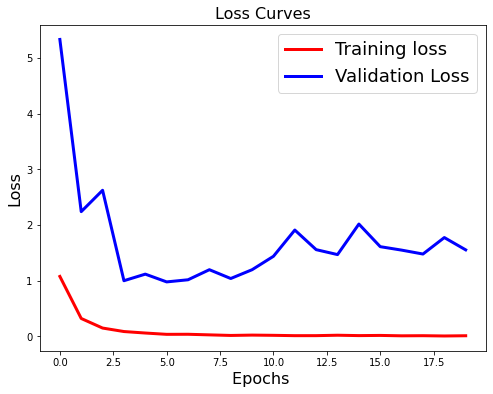

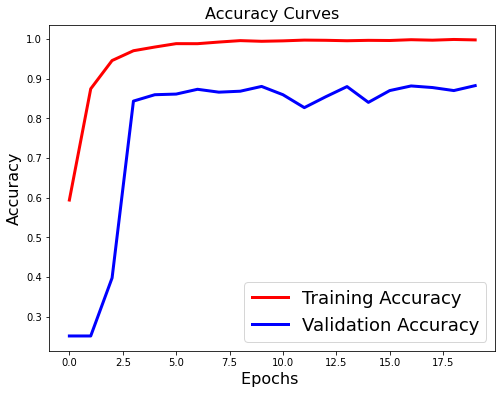

In [ ]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

### Resnet50 Confusion Matrix

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import itertools
import seaborn as sn
import pandas as pd

In [ ]:
true_labels = generator_test.classes
predictions = new_model.predict_generator(generator_test)

y_true = true_labels
y_pred = np.array([np.argmax(x) for x in predictions])

acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
clr = classification_report(y_true, y_pred, target_names = CLASS_NAMES)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Test Accuracy 88.21873743466023%
Classification Report:
----------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.86      0.86      0.86       623
  LYMPHOCYTE       1.00      0.99      0.99       620
    MONOCYTE       0.99      0.75      0.85       620
  NEUTROPHIL       0.75      0.93      0.83       624

    accuracy                           0.88      2487
   macro avg       0.90      0.88      0.88      2487
weighted avg       0.90      0.88      0.88      2487



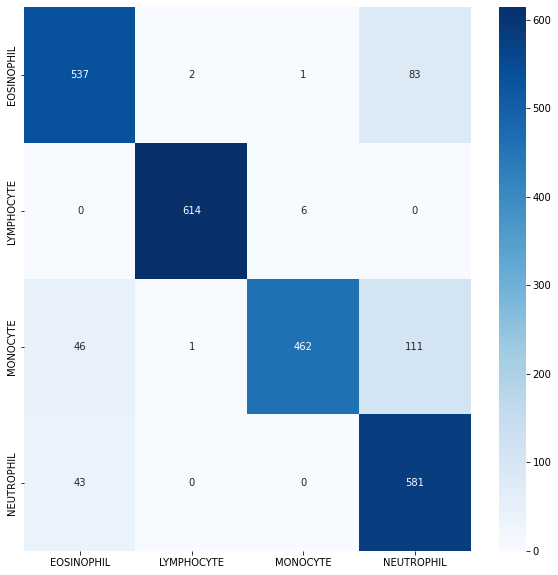

In [ ]:
print(f"Test Accuracy {acc * 100}%")
df_cm = pd.DataFrame(cm, index = CLASS_NAMES,
                       columns = CLASS_NAMES)
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

print("Classification Report:\n----------------------\n", clr)

### Resnet50 GradCam

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/BloodCells/saved_models/bloodcells_resnet50.h5')

In [ ]:
image = cv2.imread('/content/drive/MyDrive/BloodCells/dataset2-master/dataset2-master/images/TEST/EOSINOPHIL/_0_1616.jpeg')
image = cv2.resize(image, (224, 224))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = model.predict(image) 
i = np.argmax(preds[0])

icam = GradCAM(model, i, 'conv5_block3_out') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread('/content/drive/MyDrive/BloodCells/dataset2-master/dataset2-master/images/TEST/EOSINOPHIL/_0_1616.jpeg')
image = cv2.resize(image, (224, 224))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

1/1 [==============================] - 1s 1s/step
(224, 224) (224, 224, 3)


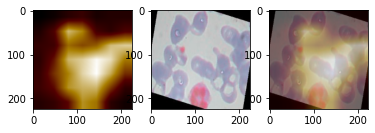

In [ ]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

# Modified Resnet50

In [ ]:
model2 = ResNet50(include_top=False,input_shape=(224, 224, 3), weights='imagenet')

In [ ]:
input_shape = (224,224)

In [ ]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)


datagen_test = ImageDataGenerator(rescale=1./255)


batch_size = 32
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [ ]:
def print_layer_trainable():
    for layer in model2.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))


print_layer_trainable()

True:	input_3
True:	conv1_pad
True:	conv1_conv
True:	conv1_bn
True:	conv1_relu
True:	pool1_pad
True:	pool1_pool
True:	conv2_block1_1_conv
True:	conv2_block1_1_bn
True:	conv2_block1_1_relu
True:	conv2_block1_2_conv
True:	conv2_block1_2_bn
True:	conv2_block1_2_relu
True:	conv2_block1_0_conv
True:	conv2_block1_3_conv
True:	conv2_block1_0_bn
True:	conv2_block1_3_bn
True:	conv2_block1_add
True:	conv2_block1_out
True:	conv2_block2_1_conv
True:	conv2_block2_1_bn
True:	conv2_block2_1_relu
True:	conv2_block2_2_conv
True:	conv2_block2_2_bn
True:	conv2_block2_2_relu
True:	conv2_block2_3_conv
True:	conv2_block2_3_bn
True:	conv2_block2_add
True:	conv2_block2_out
True:	conv2_block3_1_conv
True:	conv2_block3_1_bn
True:	conv2_block3_1_relu
True:	conv2_block3_2_conv
True:	conv2_block3_2_bn
True:	conv2_block3_2_relu
True:	conv2_block3_3_conv
True:	conv2_block3_3_bn
True:	conv2_block3_add
True:	conv2_block3_out
True:	conv3_block1_1_conv
True:	conv3_block1_1_bn
True:	conv3_block1_1_relu
True:	conv3_block1

In [ ]:
transfer_layer = model2.get_layer('conv5_block3_out')
conv_model = Model(inputs=model2.input, outputs=transfer_layer.output)

In [ ]:
last_layer = model2.get_layer('conv5_block3_out').output
out = Flatten()(last_layer)
out = Dense(512, activation='relu', name='dense_1')(out)
out = Dropout(0.5)(out)
out = Dense(256, activation='relu', name='dense_2')(out)
out = Dropout(0.5)(out)
out = Dense(128, activation='relu', name='dense_3')(out)
out = Dropout(0.5)(out)
out = Dense(64, activation='relu', name='dense_4')(out)
out = Dense(num_classes, activation='softmax', name='prediction')(out)
new_model = Model(model2.input, out)

In [ ]:
# new_model = Sequential()

# new_model.add(conv_model)

# new_model.add(Flatten())


# new_model.add(Dense(512, activation='relu'))
# new_model.add(Dropout(0.5))
# new_model.add(Dense(256, activation='relu'))
# new_model.add(Dropout(0.5))
# new_model.add(Dense(128, activation='relu'))
# new_model.add(Dropout(0.5))
# new_model.add(Dense(64, activation='relu'))


# new_model.add(Dense(4, activation='softmax'))

In [ ]:
optimizer = Adam(learning_rate=1e-5)
loss = 'categorical_crossentropy'
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), 
           FalseNegatives(name='fn'), 'accuracy' , Precision(name='precision'), Recall(name='recall'), tfa.metrics.F1Score(4, name='f1'), 
           AUC(name='auc'), SpecificityAtSensitivity(0.5, num_thresholds=200, name='sen')]


new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
epochs = 20

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

#steps_per_epoch = 20
#steps_test = 100
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/20
311/311 [==============================] - 192s 587ms/step - loss: 1.8074 - tp: 1307.0000 - fp: 3563.0000 - tn: 26308.0000 - fn: 8650.0000 - accuracy: 0.2698 - precision: 0.2684 - recall: 0.1313 - f1: 0.2548 - auc: 0.5182 - sen: 0.5151 - val_loss: 1.4328 - val_tp: 1.0000 - val_fp: 4.0000 - val_tn: 7457.0000 - val_fn: 2486.0000 - val_accuracy: 0.2509 - val_precision: 0.2000 - val_recall: 4.0209e-04 - val_f1: 0.1480 - val_auc: 0.4961 - val_sen: 0.4734
Epoch 2/20
311/311 [==============================] - 198s 635ms/step - loss: 1.4473 - tp: 484.0000 - fp: 918.0000 - tn: 28953.0000 - fn: 9473.0000 - accuracy: 0.2922 - precision: 0.3452 - recall: 0.0486 - f1: 0.2784 - auc: 0.5458 - sen: 0.5570 - val_loss: 1.3946 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 7461.0000 - val_fn: 2487.0000 - val_accuracy: 0.2525 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.2194 - val_auc: 0.5014 - val_sen: 0.4471
Epoch 3/20
311/311 [==============================] - 165s 5

In [ ]:
new_model.save('/content/drive/MyDrive/BloodCells/saved_models/bloodcells_m_resnet50.h5')

### M-Resnet50 Accuracy and Loss

In [ ]:
scores = new_model.evaluate_generator(generator_test, steps_test)
scores

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[1.2013967037200928,
 2224.0,
 260.0,
 7201.0,
 263.0,
 0.8942500948905945,
 0.8953301310539246,
 0.8942500948905945,
 array([0.90625   , 1.        , 0.8550323 , 0.82229966], dtype=float32),
 0.9404040575027466,
 0.9738640785217285]

Text(0.5, 1.0, 'Accuracy Curves')

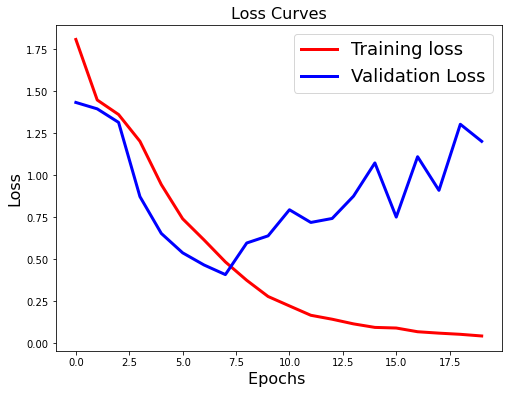

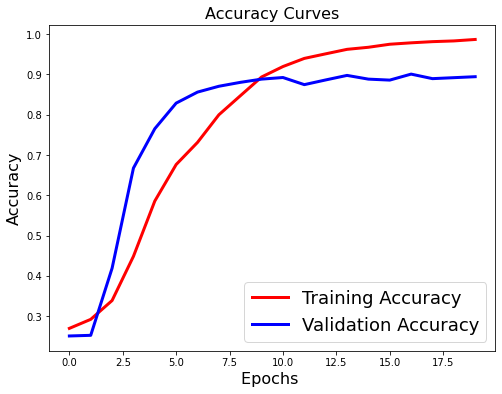

In [ ]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

### M-Resnet50 Confusion Matrix

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import itertools
import seaborn as sn
import pandas as pd

In [ ]:
true_labels = generator_test.classes
predictions = new_model.predict_generator(generator_test)

y_true = true_labels
y_pred = np.array([np.argmax(x) for x in predictions])

acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
clr = classification_report(y_true, y_pred, target_names = CLASS_NAMES)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Test Accuracy 89.42501005227182%
Classification Report:
----------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.93      0.88      0.91       623
  LYMPHOCYTE       1.00      1.00      1.00       620
    MONOCYTE       1.00      0.75      0.86       620
  NEUTROPHIL       0.73      0.95      0.82       624

    accuracy                           0.89      2487
   macro avg       0.91      0.89      0.90      2487
weighted avg       0.91      0.89      0.90      2487



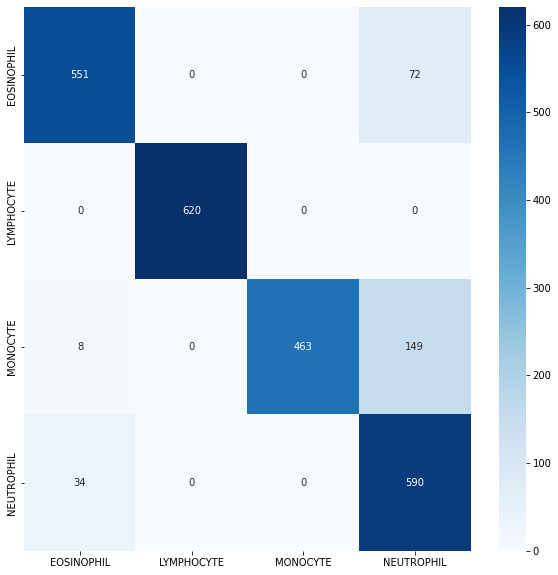

In [ ]:
print(f"Test Accuracy {acc * 100}%")
df_cm = pd.DataFrame(cm, index = CLASS_NAMES,
                       columns = CLASS_NAMES)
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

print("Classification Report:\n----------------------\n", clr)

### M-Resnet50 GradCam

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/BloodCells/saved_models/bloodcells_m_resnet50.h5')

In [ ]:
image = cv2.imread('/content/drive/MyDrive/BloodCells/dataset2-master/dataset2-master/images/TEST/EOSINOPHIL/_0_1616.jpeg')
image = cv2.resize(image, (224, 224))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = model.predict(image) 
i = np.argmax(preds[0])

icam = GradCAM(model, i, 'conv5_block3_out') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread('/content/drive/MyDrive/BloodCells/dataset2-master/dataset2-master/images/TEST/EOSINOPHIL/_0_1616.jpeg')
image = cv2.resize(image, (224, 224))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

1/1 [==============================] - 1s 829ms/step
(224, 224) (224, 224, 3)


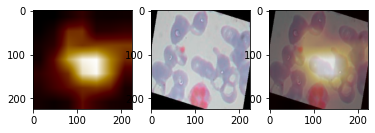

In [ ]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

# EfficientNetb0

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input, decode_predictions

In [ ]:
model3 = EfficientNetB0(include_top=False,input_shape=(224, 224, 3), weights='imagenet')

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
input_shape = (224,224)

In [ ]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)


datagen_test = ImageDataGenerator(rescale=1./255)


batch_size = 32
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)


Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [ ]:
def print_layer_trainable():
    for layer in model3.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))


print_layer_trainable()

True:	input_4
True:	rescaling
True:	normalization
True:	tf.math.truediv
True:	stem_conv_pad
True:	stem_conv
True:	stem_bn
True:	stem_activation
True:	block1a_dwconv
True:	block1a_bn
True:	block1a_activation
True:	block1a_se_squeeze
True:	block1a_se_reshape
True:	block1a_se_reduce
True:	block1a_se_expand
True:	block1a_se_excite
True:	block1a_project_conv
True:	block1a_project_bn
True:	block2a_expand_conv
True:	block2a_expand_bn
True:	block2a_expand_activation
True:	block2a_dwconv_pad
True:	block2a_dwconv
True:	block2a_bn
True:	block2a_activation
True:	block2a_se_squeeze
True:	block2a_se_reshape
True:	block2a_se_reduce
True:	block2a_se_expand
True:	block2a_se_excite
True:	block2a_project_conv
True:	block2a_project_bn
True:	block2b_expand_conv
True:	block2b_expand_bn
True:	block2b_expand_activation
True:	block2b_dwconv
True:	block2b_bn
True:	block2b_activation
True:	block2b_se_squeeze
True:	block2b_se_reshape
True:	block2b_se_reduce
True:	block2b_se_expand
True:	block2b_se_excite
True:	bl

In [ ]:
# transfer_layer = model1.get_layer('top_activation')
# conv_model = Model(inputs=model1.input, outputs=transfer_layer.output)

In [ ]:
last_layer = model3.get_layer('top_activation').output
out = Flatten()(last_layer)
out = Dense(1024, activation='relu', name='dense_1')(out)
out = Dropout(0.5)(out)
out = Dense(512, activation='relu', name='dense_2')(out)
out = Dense(num_classes, activation='softmax', name='prediction')(out)
new_model = Model(model3.input, out)

In [ ]:
# new_model = Sequential()

# new_model.add(conv_model)

# new_model.add(Flatten())


# new_model.add(Dense(1024, activation='relu'))
# new_model.add(Dropout(0.5))
# new_model.add(Dense(512, activation='relu'))

# new_model.add(Dense(4, activation='softmax'))

In [ ]:
optimizer = Adam(learning_rate=1e-5)
loss = 'categorical_crossentropy'
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), 
           FalseNegatives(name='fn'), 'accuracy' , Precision(name='precision'), Recall(name='recall'), tfa.metrics.F1Score(4, name='f1'), 
           AUC(name='auc'), SpecificityAtSensitivity(0.5, num_thresholds=200, name='sen')]


new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
epochs = 20

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

#steps_per_epoch = 20
#steps_test = 100
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/20
311/311 [==============================] - 178s 534ms/step - loss: 1.2968 - tp: 2758.0000 - fp: 2621.0000 - tn: 27250.0000 - fn: 7199.0000 - accuracy: 0.4415 - precision: 0.5127 - recall: 0.2770 - f1: 0.4412 - auc: 0.7002 - sen: 0.7747 - val_loss: 1.4823 - val_tp: 9.0000 - val_fp: 25.0000 - val_tn: 7436.0000 - val_fn: 2478.0000 - val_accuracy: 0.2288 - val_precision: 0.2647 - val_recall: 0.0036 - val_f1: 0.1486 - val_auc: 0.4882 - val_sen: 0.4800
Epoch 2/20
311/311 [==============================] - 161s 515ms/step - loss: 0.7143 - tp: 6174.0000 - fp: 1683.0000 - tn: 28188.0000 - fn: 3783.0000 - accuracy: 0.7108 - precision: 0.7858 - recall: 0.6201 - f1: 0.7094 - auc: 0.9122 - sen: 0.9715 - val_loss: 1.2538 - val_tp: 483.0000 - val_fp: 416.0000 - val_tn: 7045.0000 - val_fn: 2004.0000 - val_accuracy: 0.4150 - val_precision: 0.5373 - val_recall: 0.1942 - val_f1: 0.4106 - val_auc: 0.6950 - val_sen: 0.7393
Epoch 3/20
311/311 [==============================] - 162s 519ms/step - l

In [ ]:
new_model.save('/content/drive/MyDrive/BloodCells/saved_models/bloodcells_efficientnetb0.h5')

### EfficientNetb0 Accuracy and Loss

In [ ]:
scores = new_model.evaluate_generator(generator_test, steps_test)
scores

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[1.3521244525909424,
 1922.0,
 547.0,
 6914.0,
 565.0,
 0.774829089641571,
 0.7784528136253357,
 0.7728186845779419,
 array([0.7461368 , 0.9910931 , 0.63815784, 0.70435977], dtype=float32),
 0.904474139213562,
 0.982308030128479]

Text(0.5, 1.0, 'Accuracy Curves')

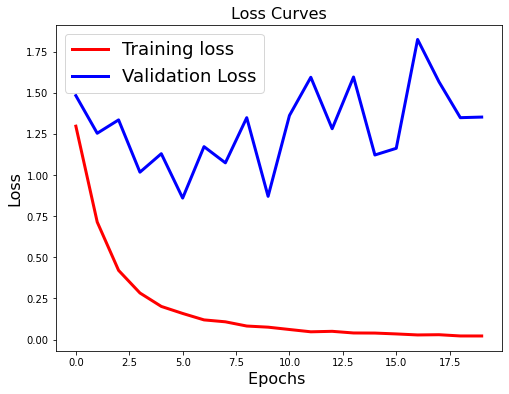

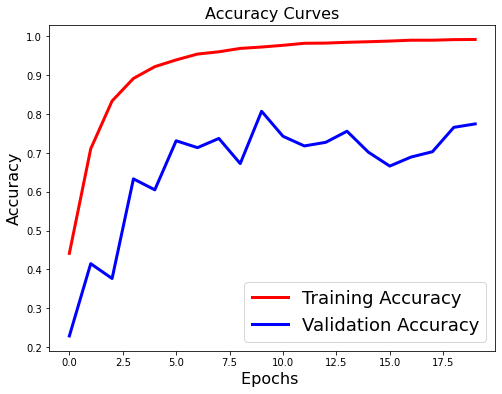

In [ ]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

### EfficientNetb0 Confusion Matrix

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import itertools
import seaborn as sn
import pandas as pd

In [ ]:
true_labels = generator_test.classes
predictions = new_model.predict_generator(generator_test)

y_true = true_labels
y_pred = np.array([np.argmax(x) for x in predictions])

acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
clr = classification_report(y_true, y_pred, target_names = CLASS_NAMES)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Test Accuracy 77.48291113791717%
Classification Report:
----------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.69      0.81      0.75       623
  LYMPHOCYTE       1.00      0.99      0.99       620
    MONOCYTE       1.00      0.47      0.64       620
  NEUTROPHIL       0.61      0.83      0.70       624

    accuracy                           0.77      2487
   macro avg       0.82      0.77      0.77      2487
weighted avg       0.82      0.77      0.77      2487



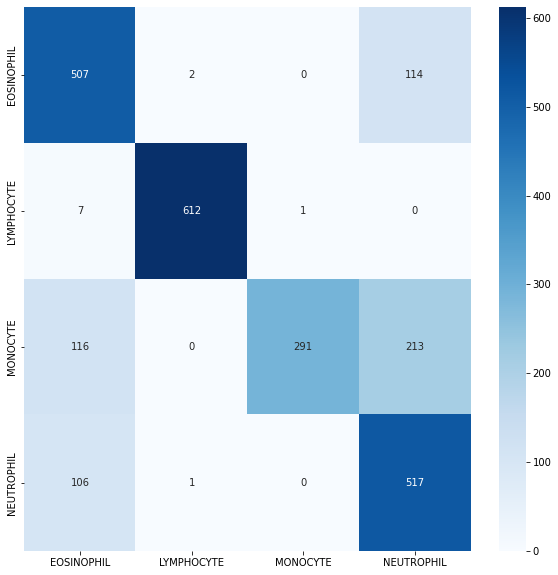

In [ ]:
print(f"Test Accuracy {acc * 100}%")
df_cm = pd.DataFrame(cm, index = CLASS_NAMES,
                       columns = CLASS_NAMES)
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

print("Classification Report:\n----------------------\n", clr)

### EfficientNetb0 GradCam

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/BloodCells/saved_models/bloodcells_efficientnetb0.h5')

In [ ]:
image = cv2.imread('/content/drive/MyDrive/BloodCells/dataset2-master/dataset2-master/images/TEST/EOSINOPHIL/_0_1616.jpeg')
image = cv2.resize(image, (224, 224))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = model.predict(image) 
i = np.argmax(preds[0])

icam = GradCAM(model, i, 'top_activation') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread('/content/drive/MyDrive/BloodCells/dataset2-master/dataset2-master/images/TEST/EOSINOPHIL/_0_1616.jpeg')
image = cv2.resize(image, (224, 224))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

1/1 [==============================] - 2s 2s/step
(224, 224) (224, 224, 3)


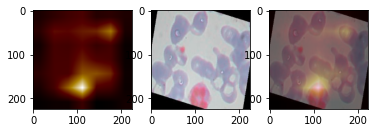

In [ ]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

# Xception

In [ ]:
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions

In [ ]:
model4 = Xception(include_top=False,input_shape=(224, 224, 3), weights='imagenet')

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
input_shape = (224,224)

In [ ]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)


datagen_test = ImageDataGenerator(rescale=1./255)


batch_size = 32
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)


Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [ ]:
def print_layer_trainable():
    for layer in model4.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))


print_layer_trainable()

True:	input_5
True:	block1_conv1
True:	block1_conv1_bn
True:	block1_conv1_act
True:	block1_conv2
True:	block1_conv2_bn
True:	block1_conv2_act
True:	block2_sepconv1
True:	block2_sepconv1_bn
True:	block2_sepconv2_act
True:	block2_sepconv2
True:	block2_sepconv2_bn
True:	conv2d
True:	block2_pool
True:	batch_normalization
True:	add
True:	block3_sepconv1_act
True:	block3_sepconv1
True:	block3_sepconv1_bn
True:	block3_sepconv2_act
True:	block3_sepconv2
True:	block3_sepconv2_bn
True:	conv2d_1
True:	block3_pool
True:	batch_normalization_1
True:	add_1
True:	block4_sepconv1_act
True:	block4_sepconv1
True:	block4_sepconv1_bn
True:	block4_sepconv2_act
True:	block4_sepconv2
True:	block4_sepconv2_bn
True:	conv2d_2
True:	block4_pool
True:	batch_normalization_2
True:	add_2
True:	block5_sepconv1_act
True:	block5_sepconv1
True:	block5_sepconv1_bn
True:	block5_sepconv2_act
True:	block5_sepconv2
True:	block5_sepconv2_bn
True:	block5_sepconv3_act
True:	block5_sepconv3
True:	block5_sepconv3_bn
True:	add_3
Tr

In [ ]:
# transfer_layer = model1.get_layer('block14_sepconv2_act')
# conv_model = Model(inputs=model1.input, outputs=transfer_layer.output)

In [ ]:
last_layer = model4.get_layer('block14_sepconv2_act').output
out = Flatten()(last_layer)
out = Dense(1024, activation='relu', name='dense_1')(out)
out = Dropout(0.5)(out)
out = Dense(512, activation='relu', name='dense_2')(out)
out = Dense(num_classes, activation='softmax', name='prediction')(out)
new_model = Model(model4.input, out)

In [ ]:
# new_model = Sequential()

# new_model.add(conv_model)

# new_model.add(Flatten())


# new_model.add(Dense(1024, activation='relu'))
# new_model.add(Dropout(0.5))
# new_model.add(Dense(512, activation='relu'))


# new_model.add(Dense(4, activation='softmax'))

In [ ]:
optimizer = Adam(learning_rate=1e-5)
loss = 'categorical_crossentropy'
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), 
           FalseNegatives(name='fn'), 'accuracy' , Precision(name='precision'), Recall(name='recall'), tfa.metrics.F1Score(4, name='f1'), 
           AUC(name='auc'), SpecificityAtSensitivity(0.5, num_thresholds=200, name='sen')]


new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
epochs = 20

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

#steps_per_epoch = 20
#steps_test = 100
history = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/20
311/311 [==============================] - 221s 680ms/step - loss: 0.9907 - tp: 3644.0000 - fp: 1260.0000 - tn: 28611.0000 - fn: 6313.0000 - accuracy: 0.5697 - precision: 0.7431 - recall: 0.3660 - f1: 0.5696 - auc: 0.8220 - sen: 0.9003 - val_loss: 1.1062 - val_tp: 1563.0000 - val_fp: 720.0000 - val_tn: 6741.0000 - val_fn: 924.0000 - val_accuracy: 0.6590 - val_precision: 0.6846 - val_recall: 0.6285 - val_f1: 0.6597 - val_auc: 0.8528 - val_sen: 0.9505
Epoch 2/20
311/311 [==============================] - 206s 662ms/step - loss: 0.3149 - tp: 8524.0000 - fp: 991.0000 - tn: 28880.0000 - fn: 1433.0000 - accuracy: 0.8761 - precision: 0.8958 - recall: 0.8561 - f1: 0.8756 - auc: 0.9821 - sen: 0.9981 - val_loss: 0.9581 - val_tp: 1959.0000 - val_fp: 478.0000 - val_tn: 6983.0000 - val_fn: 528.0000 - val_accuracy: 0.7973 - val_precision: 0.8039 - val_recall: 0.7877 - val_f1: 0.8020 - val_auc: 0.9172 - val_sen: 0.9799
Epoch 3/20
311/311 [==============================] - 207s 663ms/step -

In [ ]:
new_model.save('/content/drive/MyDrive/BloodCells/saved_models/bloodcells_xception.h5')

### Xception Accuracy and Loss

In [ ]:
scores = new_model.evaluate_generator(generator_test, steps_test)
scores

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[1.982400894165039,
 2117.0,
 369.0,
 7092.0,
 370.0,
 0.8512263894081116,
 0.8515687584877014,
 0.8512263894081116,
 array([0.8430873 , 0.9854839 , 0.82474226, 0.76478493], dtype=float32),
 0.9165660738945007,
 0.9658222794532776]

Text(0.5, 1.0, 'Accuracy Curves')

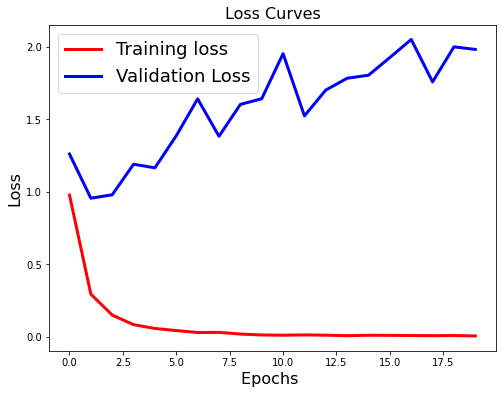

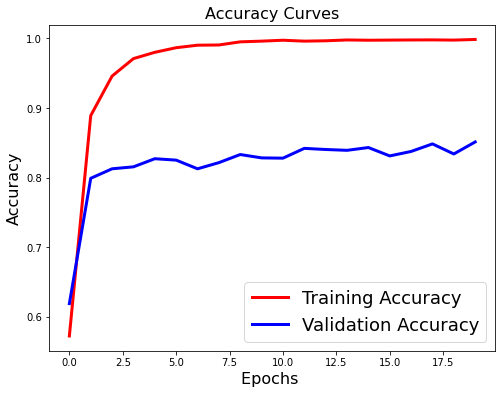

In [ ]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

### Xception Confusion Matrix

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import itertools
import seaborn as sn
import pandas as pd

In [ ]:
true_labels = generator_test.classes
predictions = new_model.predict_generator(generator_test)

y_true = true_labels
y_pred = np.array([np.argmax(x) for x in predictions])

acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
clr = classification_report(y_true, y_pred, target_names = CLASS_NAMES)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Test Accuracy 84.6401286690792%
Classification Report:
----------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.91      0.75      0.82       623
  LYMPHOCYTE       0.96      0.97      0.96       620
    MONOCYTE       0.97      0.74      0.84       620
  NEUTROPHIL       0.66      0.93      0.77       624

    accuracy                           0.85      2487
   macro avg       0.87      0.85      0.85      2487
weighted avg       0.87      0.85      0.85      2487



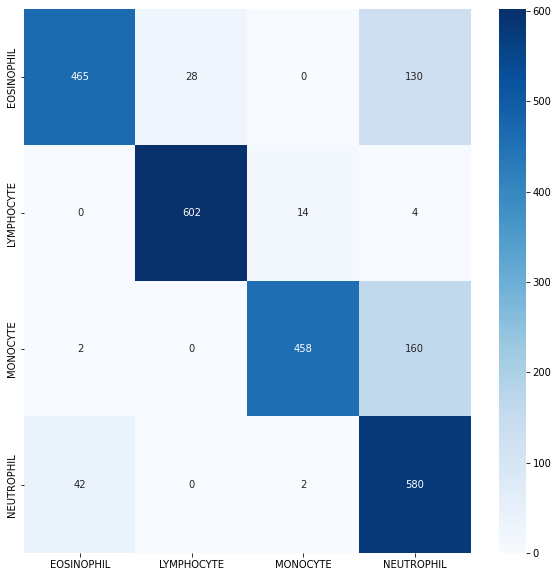

In [ ]:
print(f"Test Accuracy {acc * 100}%")
df_cm = pd.DataFrame(cm, index = CLASS_NAMES,
                       columns = CLASS_NAMES)
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

print("Classification Report:\n----------------------\n", clr)

### Xception GradCam

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/BloodCells/saved_models/bloodcells_xception.h5')

In [ ]:
image = cv2.imread('/content/drive/MyDrive/BloodCells/dataset2-master/dataset2-master/images/TEST/EOSINOPHIL/_0_1616.jpeg')
image = cv2.resize(image, (224, 224))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = model.predict(image) 
i = np.argmax(preds[0])

icam = GradCAM(model, i, 'block14_sepconv2_act') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread('/content/drive/MyDrive/BloodCells/dataset2-master/dataset2-master/images/TEST/EOSINOPHIL/_0_1616.jpeg')
image = cv2.resize(image, (224, 224))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

1/1 [==============================] - 1s 1s/step
(224, 224) (224, 224, 3)


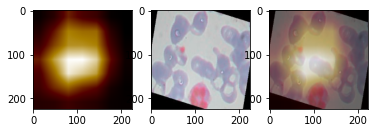

In [ ]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

# Graph

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


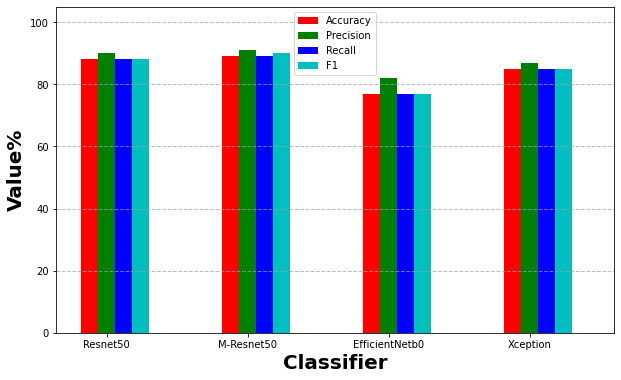

In [60]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.12
fig = plt.subplots(figsize =(10, 6))
 
# set height of bar
Accuracy = np.array([0.88, 0.89, 0.77, 0.85])*100
Precision = np.array([0.90, 0.91, 0.82, 0.87])*100
Recall = np.array([0.88, 0.89, 0.77, 0.85])*100
F1 = np.array([0.88, 0.90, 0.77, 0.85])*100
F2 = np.array([1, 1, 1, 1 ])*100


# Set position of bar on X axis

br1 = np.arange(len(Accuracy))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]

# 'accuracy', 'precision', 'recall', 'f1'

# Make the plot
plt.bar(br1, Accuracy, color ='r', width = barWidth,
        edgecolor ='', label ='Accuracy')
plt.bar(br2, Precision, color ='g', width = barWidth,
        edgecolor ='', label ='Precision')
plt.bar(br3, Recall, color ='b', width = barWidth,
        edgecolor ='', label ='Recall')
plt.bar(br4, F1, color ='c', width = barWidth,
        edgecolor ='', label ='F1')
plt.bar(br5, F2, color ='w', width = barWidth,
        edgecolor ='white')
plt.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.7)

# Adding Xticks
plt.xlabel('Classifier', fontweight ='bold', fontsize = 20)
plt.ylabel('Value%', fontweight ='bold', fontsize = 20)
plt.xticks([r + barWidth for r in range(len(Accuracy))],
        ['Resnet50', 'M-Resnet50', 'EfficientNetb0', 'Xception'])
 
plt.legend()
plt.show()